# Using fasttext embeddings for stocks prediction

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Import stock data
df = pd.read_csv('../data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

training_data_len = math.ceil(len(df) * .8)
training_data_len

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)


(1592, 1) (397, 1)


Import fasttext embeddings. Embeddings obtained and prepared beforehand and are now stored in .npy file for quicker use

In [3]:
ft_embeddings = np.load('../fasttext_embeddings.npy')
ft_embeddings.shape

(1989, 300)

In [4]:
ft_train = ft_embeddings[:training_data_len]
ft_test = ft_embeddings[training_data_len:]
print(ft_train.shape, ft_test.shape)

(1592, 300) (397, 300)


In [5]:
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

Scaling prices with MinMaxScaler because LSTM model is sensitive to scale

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)

print(scaled_train[:5])

scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5]) 


[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [7]:
# Create sequences and labels for training data
sequence_length = 50 # Number of time steps to look back
X_train_emb, X_train, y_train = [], [], []
# asd = []

for i in range(len(scaled_train) - sequence_length):
    X_train_emb.append(ft_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
    X_train.append(scaled_train[i:i+sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train_emb = np.array(X_train_emb)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).float()
y_train = torch.tensor(y_train, dtype=torch.float32).float()
X_train_emb = torch.tensor(X_train_emb, dtype=torch.float32).float().squeeze()


X_train.shape, X_train_emb.shape, y_train.shape


(torch.Size([1542, 50, 1]),
 torch.Size([1542, 50, 300]),
 torch.Size([1542, 50, 1]))

In [8]:
X_train = torch.cat((X_train, X_train_emb), axis=2)

In [10]:
# Create sequences and labels for testing data
sequence_length = 30  # Number of time steps to look back
X_test, y_test = [], []
X_test_emb = []

for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
    X_test_emb.append(ft_test[i:i+sequence_length])

X_test, X_test_emb, y_test = np.array(X_test), np.array(X_test_emb), np.array(y_test)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
X_test_emb = torch.tensor(X_test_emb, dtype=torch.float32).squeeze()
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, X_test_emb.shape, y_test.shape

(torch.Size([367, 30, 1]),
 torch.Size([367, 30, 300]),
 torch.Size([367, 30, 1]))

In [11]:
X_test = torch.cat((X_test, X_test_emb), axis=2)

In [12]:
class LSTMModel(nn.Module):
    """
	input_size : number of features in input at each time step
	hidden_size : Number of LSTM units
	num_layers : number of LSTM layers
    """
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__() #initializes the parent class nn.Module
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(64, 1)

    def forward(self, p):
        out, _ = self.lstm(p)
        out = self.linear(out)
        return out


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [14]:
input_size = 302
num_layers = 2
hidden_size = 64
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers).to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(302, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
batch_size = 16
# Create DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for batch training
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
num_epochs = 50
train_hist =[]
test_hist =[]
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0

	# Training
	model.train()
	for batch_price, batch_y in train_loader:
		batch_price, batch_y = batch_price.to(device), batch_y.to(device)
		predictions = model(batch_price)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_hist.append(average_loss)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0

		for batch_price,  batch_y_test in test_loader:
			batch_price, batch_y_test = batch_price.to(device), batch_y_test.to(device)
			predictions_test = model(batch_price)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_hist.append(average_test_loss)
	if (epoch+1)%10==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [10/50] - Training Loss: 0.0002, Test Loss: 0.0049
Epoch [20/50] - Training Loss: 0.0001, Test Loss: 0.0042
Epoch [30/50] - Training Loss: 0.0001, Test Loss: 0.0042
Epoch [40/50] - Training Loss: 0.0000, Test Loss: 0.0041
Epoch [50/50] - Training Loss: 0.0000, Test Loss: 0.0041


## Evaluation

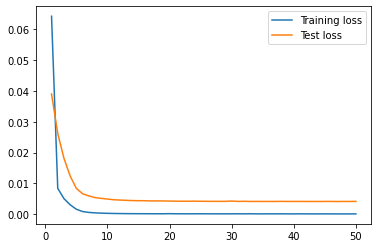

In [17]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

## Calculate RMSE

In [18]:
### Lets Do the prediction and check performance metrics
with torch.no_grad():
    train_predict=model(X_train)
    test_predict=model(X_test)


In [19]:
train_predict = train_predict.squeeze()
test_predict = test_predict.squeeze()

In [20]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
### Calculate RMSE performance metrics
t = scaler.inverse_transform(y_train.squeeze())
math.sqrt(mean_squared_error(t,train_predict))

13.962031174946512

In [22]:
tt = scaler.inverse_transform(y_test.squeeze())
math.sqrt(mean_squared_error(tt,test_predict))

169.93569939132175

## Predictions

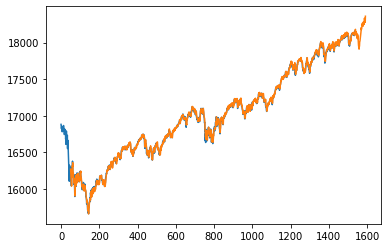

In [23]:
### Plotting
look_back=50
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict[:, -1].reshape(-1, 1)


plt.plot(t[:, 0])
plt.plot(trainPredictPlot)

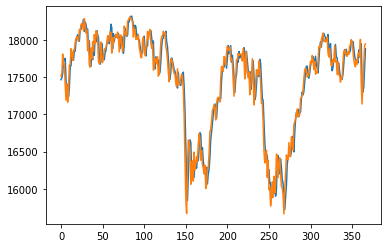

In [24]:
plt.plot(test_predict[:, -1])
plt.plot(tt[:, -1])
plt.show()